In [1]:
using JuMP, Ipopt, Plots

In [2]:
#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys,"tol",1e-14)
set_optimizer_attribute(sys,"max_iter",1000)

#Parameters

# constants
w = 0.4
l = 0.6
ε = 1e-1

# initial data
x0 = 0 
y0 = 0 
θ0 = π/7
β1_0 = 0
β2_0 = 0


# final data
xf = 4
yf = 7
θf = 3*π/2 

P1 =50
P2 =50
P3 = 50
P4 =50
P = P1+P2+P3+P4

# Bounds for variables

JuMP.@variables(sys,begin
    x[1:P]           # x 
    y[1:P]           # y 
    θ[1:P]           # theta
    β1[1:P]          # beta1 
    β2[1:P]          # beta2
     0 ≤ Δt_1≤ 1 
     0 ≤ Δt_2≤ 1 
     0 ≤ Δt_3≤ 1 
     0 ≤ Δt_4≤ 1
    end)

# Objective
@objective(sys,Min,Δt_1*P1 +Δt_2*P2+ Δt_3*P3+Δt_4*P4 )


# Constraints 

u=transpose([ones(1,P1) zeros(1,P2) +ones(1,P3) zeros(1,P4)])

@constraints(sys,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    x[P] == xf
    y[P] == yf
    θ[P] == θf
    β1[P]^2+β2[P]^2 ≤ ε^2
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : P1-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_1* (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_1 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_1* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_1 * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t1[j = 1:(P1-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 *Δt_1*(u[j]+ u[j+1]) )

for j in P1 : P1+P2-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_2 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_2 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_2* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_2* (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end
@NLconstraint(sys,p_t2[j = P1:(P1+P2-1)],  # theta ' = u 
        θ[j+1] == θ[j]+ 0.5 *Δt_2*(u[j]+ u[j+1]) )

for j in P1+P2 : P1+P2+P3-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_3 * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_3 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_3* (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_3* (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t3[j = P1+P2:(P1+P2+P3-1)],  # theta ' = u 
        θ[j+1] == θ[j]+0.5* Δt_3*(u[j]+ u[j+1])  )

for j in P1+P2+P3 : P-1
    @NLconstraint(sys, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt_4* (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt_4 *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt_4 * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt_4 * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
end

@NLconstraint(sys,p_t4[j = P1+P2+P3:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j]+ 0.5 *Δt_4*(u[j]+ u[j+1]) )


#Solve for the control and state
println("Solving...")
status = optimize!(sys)
println("Solver status : ",status)

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4187
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     6569

Total number of variables............................:     1004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total numb

t1 = 1.1210372509565811
t2 = 9.519420009769053
t3 = 12.608768774225059
tf = 14.862210727709638


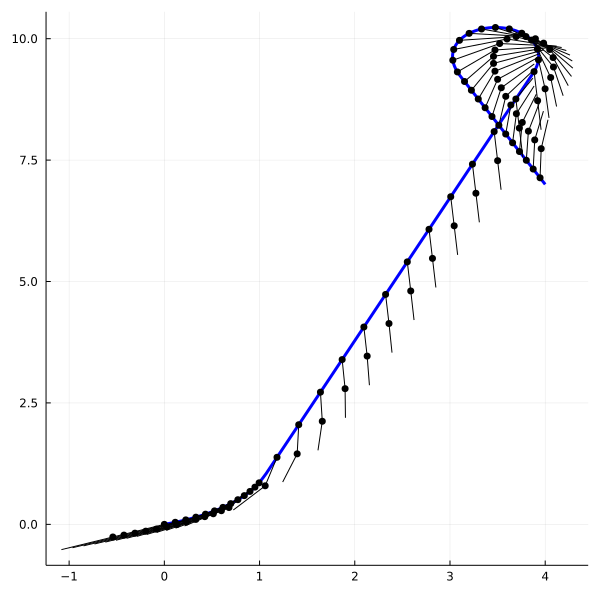

In [3]:
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
u1 = value.(u)

println("t1 = ",value.(Δt_1*P1))
println("t2 = ",value.(Δt_1*P1+Δt_2*P2))
println("t3 = ",value.(Δt_1*P1+Δt_2*P2+Δt_3*P3))
println("tf = ", value.(Δt_1*P1+Δt_2*P2+Δt_3*P3+Δt_4*P4))

#plots : states 


t1 = value.(Δt_1)*P1
t2 = value.(Δt_2)*P2
t3 = value.(Δt_3)*P3
t4 = value.(Δt_4)*P4

vec1 = value.(Δt_1)*(0:P1-1)
vec2 = value.(Δt_2)*(0:P2-1)+ t1*ones(P2)
vec3 = value.(Δt_3)*(0:P3-1)+(t1+t2)*ones(P3)
vec4 = value.(Δt_4)*(0:P4-1)+(t1+t2+t3)*ones(P4)

t = vcat(vec1,vec2,vec3,vec4) 

x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,β1_plot,β2_plot,θ_plot,u_plot, layout = (3,2))) 

#plots : trajectory 

p = plot(x1,y1, c = :blue, lw = 3)
plot!(size=(600,600))

for i = 1 :4: P-1
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    θ_1 =  β1_p +  θ_p
    θ_2 =  β2_p +  θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
end
current()

Solving...


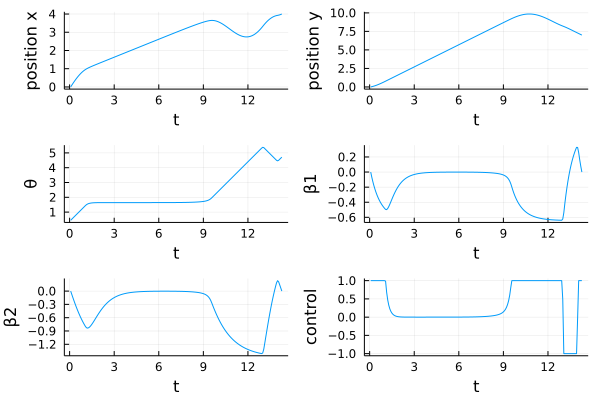

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6379
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13333

Total number of variables............................:     1401
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1205
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

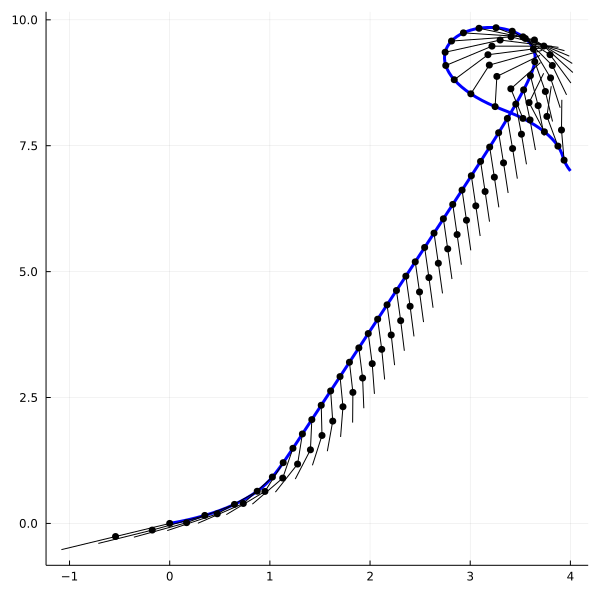

In [4]:
 #JuMP model, Ipopt solver
sys2 = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
set_optimizer_attribute(sys2,"tol",1e-14)
set_optimizer_attribute(sys2,"max_iter",1000)

#Parameters

# constants
w = 0.4
l = 0.6
μ = 10^(-4)

# initial data
x0 = 0 
y0 = 0 
θ0 = π/7
β1_0 = 0 
β2_0 = 0
c0 = 0

# final data
xf = 4
yf = 7
θf = 3*π/2
β1_f = 0
β2_f = 0

P = 200

# Bounds for variables

JuMP.@variables(sys2,begin
    x[1:P]           # x 
    y[1:P]           # y 
    θ[1:P]           # theta
    β1[1:P]          # beta1 
    β2[1:P]          # beta2
    -1 ≤ u[1:P] ≤ 1  # u, control
     0 ≤ Δt ≤ 1 
    c[1:P]
    end)

# Objective
@objective(sys2,Min,Δt+μ*c[P])

# Constraints 

@constraints(sys2,begin
    x[1] == x0
    y[1] == y0
    θ[1] == θ0
    β1[1]== β1_0
    β2[1] == β2_0
    c[1] == c0
    x[P] == xf
    y[P] == yf
    θ[P] == θf
    β1[P] == β1_f
    β2[P] == β2_f
        end)

# Dynamics : Crank-Nicolson scheme

for j in 1 : P-1
    @NLconstraint(sys2, # x' = w + cos(theta)
        x[j+1] == x[j] + 0.5 * Δt * (w + cos(θ[j]) + w + cos(θ[j+1])))
    @NLconstraint(sys2, # y' = sin(theta) 
        y[j+1] == y[j] + 0.5* Δt *(sin(θ[j])+ sin(θ[j+1])))
    @NLconstraint(sys2, #beta1 ' = -u- 1/l * sin(beta1)
        β1[j+1] == β1[j] + 0.5 * Δt * (-u[j]-(1/l)*sin(β1[j]) - u[j+1] - (1/l)*sin(β1[j+1])))
    @NLconstraint(sys2, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
        β2[j+1] == β2[j] + 0.5 *  Δt * (-u[j] - cos(β1[j])*sin(β2[j] - β1[j])/l - u[j+1] - cos(β1[j+1])*sin(β2[j+1] - β1[j+1])/l ))
    @NLconstraint(sys2, # L2-norm regulazisation on the control
        c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))
end

@NLconstraint(sys2,p_t3[j = 1:(P-1)],  # theta ' = u 
        θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

#Solve for the control and state
println("Solving...")
status = optimize!(sys2)
println("Solver status : ",status)
x1 = value.(x)
y1 = value.(y)
θ1 = value.(θ)
β_1 = value.(β1)
β_2 = value.(β2)
u1 = value.(u)
println("Cost : " , objective_value(sys2))

println("tf = ", value.(Δt)*P)


#plots : states 

Δt1 = value.(Δt)
t = (1 : P)*Δt1


x_plot = plot(t,x1,xlabel = "t", ylabel = "position x", legend = false, fmt = :png)
y_plot = plot(t,y1,xlabel = "t", ylabel = "position y", legend = false, fmt = :png)
θ_plot = plot(t,θ1,xlabel = "t", ylabel = "θ", legend = false, fmt = :png)
β1_plot = plot(t,β_1,xlabel = "t", ylabel = "β1", legend = false, fmt = :png)
β2_plot = plot(t,β_2,xlabel = "t", ylabel = "β2", legend = false, fmt = :png)
u_plot = plot(t,u1,xlabel = "t", ylabel = "control", legend = false, fmt = :png)
display(plot(x_plot,y_plot,θ_plot,β1_plot,β2_plot,u_plot, layout = (3,2)))

#plots : trajectory 
p = plot(x1,y1, c = :blue, lw = 3)
plot!(size=(600,600))

for i = 1 : 4: P 
    z = [x1[i] y1[i]]
    θ_p = θ1[i]
    β1_p = β_1[i]
    β2_p = β_2[i]
    θ_1 =  β1_p +  θ_p
    θ_2 =  β2_p +  θ_p
    z1 = z - l*[cos(θ_1) sin(θ_1)]
    z2 = z1 - l*[cos(θ_2) sin(θ_2)]
    plot!([z[1],z1[1]], [z[2],z1[2]] ,color=:black, legend = false)
    plot!([z1[1],z2[1]], [z1[2],z2[2]], color=:black, legend = false)
    plot!([z[1]],[z[2]],seriestype = :scatter, color =:black , legend = false)
    plot!([z1[1]],[z1[2]],seriestype = :scatter, color =:black , legend = false) 
    plot!(size=(600,600))
end
current()

$\Huge Comparison \; with \; the \; case\; where\; the\; control \;is \;free \;: $

$time \; t_f  \; with  \; control \; free : \; 14.280335336582873 $

$time \; t_f  \; with  \; BSBS  \; :  \; 14.862210727709638 $
